## Final Model 
With the main frequencies determined from the Fourier transforms, additional degrees of freedom can be added to the model. With precise guesses for the values of the trigonometric functions, lest-square fitting can be used. It now takes the form,
```{math}
:label: model
    f(t) = t_0\cos[(\omega_0+1/2) t] + t_1\cos[(\omega_1+1/2) t] + p_1 t +p_2 t^2 +p_3 t^3 + c_0.
```
All the parameters in the equation $f(t)$ with subscripts are constants to be fitted by the least-squares method. The Model and its residuals are plotted below. 

In [2]:
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dur_utils import colours
from scipy import stats
from matplotlib.gridspec import GridSpec

In [3]:
path_global = 'https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_gl.csv'
co2_data_global = pd.read_csv(path_global, header=0, comment='#')
path_ml =  'https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv'              
co2_data_ml = pd.read_csv(path_ml, header=0, comment='#')
co2_data_ml = co2_data_ml[co2_data_ml['sdev']>0] 

In [4]:
#The factor of 1/2 is added to the definintons of the cosine functiond, due to this being part of the definition in the inverse transform
def model(x, a_0, a_1, omega_0, omega_1, c, p_1, p_2, p_3):
    polynomial = x*p_1 + x**2*p_2 +x**3*p_3
    trig = a_0*np.cos((x + 1/2)*2*np.pi*omega_0) \
        + a_1*np.cos((x + 1/2)*2*np.pi*omega_1)
    return c + trig + polynomial

model_fit, model_error = scipy.optimize.curve_fit(model,
    co2_data_ml['decimal date'],
    co2_data_ml['average'],
    sigma = co2_data_ml['sdev'],
    p0=[5,5,1,2,0,0,0,0] # Inital Parameter Guess
    )
#chisq
model_ml = model(co2_data_ml['decimal date'], *model_fit)
model_residuals = model_ml - co2_data_ml['average']
chisq_model = np.sum((model_residuals
    / co2_data_ml['sdev'])**2
    )
nu_model = co2_data_ml['average'].shape[0] - len(model_fit)
p_model = stats.chi2.sf(chisq_model,nu_model)
chi_crit = stats.chi2.isf(.05,nu_model)
print(rf'chi^2_crit:{chi_crit:.4}')
print(rf'chi^2_min:{chisq_model:.5}')
print(rf'P(\chi^2 \geq \chi^2_{{min}};{nu_model}) = {p_model:.3}')

chi^2_crit:623.5
chi^2_min:1210.6
P(\chi^2 \geq \chi^2_{min};567) = 9.05e-49


In [10]:
#params
labels = ['a_0', 'a_1', 'omega_0', 'omega_1', 'c', 'p_1', 'p_2', 'p_3']
model_fit_params = pd.Series(model_fit,index=labels)
fname = '../output_files/co2_model_parameters.csv'
model_fit_params.to_csv(fname)
#errors
model_error_frame = pd.DataFrame(model_error, index=labels,
    columns=labels
    )
fname = '../output_files/co2_model_parameters_error.csv'

model_error_frame.to_csv(fname)

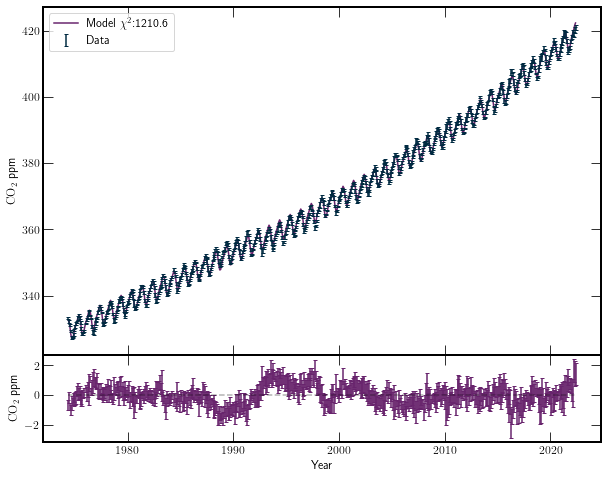

In [ ]:
fig = plt.figure(figsize=(10,8))
gs = GridSpec(2,1, height_ratios=[4,1], hspace = 0)
ax = [fig.add_subplot(i) for i in gs]
#Plotting
ax[0].plot(co2_data_ml['decimal date'],
    model_ml,
    label = rf'Model $\chi^2$:{chisq_model:.5}',
    c=colours.durham.purple
    )
ax[0].errorbar(co2_data_ml['decimal date'],
    co2_data_ml['average'],
    co2_data_ml['sdev'],
    label = 'Data',
    c=colours.durham.ink,
    linestyle = ''
    )
ax[1].errorbar(co2_data_ml['decimal date'],
    model_residuals,
    co2_data_ml['sdev'],
    c=colours.durham.purple,
    linestyle = ''
    )
ax[1].plot(co2_data_ml['decimal date'],
    np.zeros_like(co2_data_ml['decimal date']),
    linestyle = '--',
    c='black',
    alpha=0.3
    )
ax[0].legend()
ax[1].set_xlabel('Year')
for axes in ax: axes.set_ylabel(r'$\textrm{CO}_2$ ppm')

## Conclusion
The null hypothesis proposed is that the growth in $\textrm{CO}_2$ over the past few decades can be modeled by a function of the form eq. {eq}`model`,
```{math}
\mathcal{H}_0 : f(t).
```
At a significance level of $5\%$, $\chi^2_{crit} = 624$. This value is much lower than $\chi^2_{min} = 1211$, obtained by the model. Thus the null hypothesis should be rejected. 

### Discussion
The $\chi^2_{min}$ value of the model fit was substantially lower than that of previous just polynomial fits. This is reassuring as adding annual, biannual cycles in $\textrm{CO}_2$ levels corresponds with seasonal increases in $\textrm{CO}_2$ absorption by flora{cite}`seasonalco2`.

On inspection of the model's residuals, periods of increased and decreased $\textrm{CO}_2$ production are clear over our model. Therefore, one could continue testing the residuals for further structure. However, they appear uncorrelated. There does not appear to be any low-order polynomial structure to the residual pattern. Further significant increases in fit were not seen on the increase in degrees of freedom up to a P5. Reducing the degrees of freedom in the polynomial expansion produced sharp increases in the value of $\chi^2$. 

The dataset from Mauna Loa does not describe the variation in global $\textrm{CO}_2$ production expected in any given year. For example, large forest fires or volcanic eruptions will produce variance that can be measured accurately. Nonetheless, it is not described in any capacity by either the standard deviation on the measurements or the proposed model.

Additionally, the question of whether the Covid pandemic can cause a deviation from the current model is an exercise left for the reader. However, it is broken down into multiple steps. 
## Excercise 
1. Produce a model of a similar form to the current one displayed. On the data up to the end of 2018.
2. Extend the model to the start of the year 2020. Discuss whether the model is valid in this region.
3. If the model is deemed valid, extend it to the end of 2022. Then show weather wethere is a deviation due to covid.  
